In [8]:
# Delete all user-defined global variables except built-ins
for name in list(globals().keys()):
    if not name.startswith("_") and name not in ["gc", "pd", "np", "os", "sys"]:
        del globals()[name]
import gc
gc.collect()

119

In [9]:
# ===========================
# LSTM Dataset Preparation
# ===========================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Step 1: Load cleaned dataset
# ---------------------------
DATA_PATH = r"C:\Users\Deepak\OneDrive\Desktop\ObjectRegon\data\processed\merged_dataset_v4_cleaned.parquet"
df = pd.read_parquet(DATA_PATH)
print("✅ Dataset loaded:", df.shape)

# ---------------------------
# Step 2: Handle missing values
# ---------------------------
# Fill zeros for hospitalizations and vaccinations
zero_fill_cols = [
    "current_hospitalized_patients",
    "current_intensive_care_patients",
    "cumulative_persons_vaccinated",
    "cumulative_persons_fully_vaccinated"
]
df[zero_fill_cols] = df[zero_fill_cols].fillna(0)

# Forward/backward fill for weather + stringency per location
ffill_cols = ["average_temperature_celsius", "relative_humidity", "rainfall_mm", "stringency_index"]
for col in ffill_cols:
    df[col] = df.groupby("location_key")[col].transform(lambda g: g.ffill().bfill())

# Drop remaining rows with missing target
df = df.dropna(subset=["new_confirmed"])

print("✅ Missing values handled. Final shape:", df.shape)

# ---------------------------
# Step 3: Feature & target columns
# ---------------------------
feature_cols = [
    "average_temperature_celsius",
    "relative_humidity",
    "rainfall_mm",
    "current_hospitalized_patients",
    "current_intensive_care_patients",
    "cumulative_persons_vaccinated",
    "cumulative_persons_fully_vaccinated",
    "stringency_index"
]

target_col = "new_confirmed"

# ---------------------------
# Step 4: Scale features
# ---------------------------
scalers = {}
for col in feature_cols:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler  # Save scaler for inference later

# Scale target too
target_scaler = MinMaxScaler()
df[target_col] = target_scaler.fit_transform(df[[target_col]])

# ---------------------------
# Step 5: Build Dataset class
# ---------------------------
class CovidLSTMDataset(Dataset):
    def __init__(self, df, location_key, seq_len=30):
        self.seq_len = seq_len
        self.data = df[df["location_key"] == location_key].sort_values("date")
        self.features = self.data[feature_cols].values
        self.targets = self.data[target_col].values

    def __len__(self):
        return max(0, len(self.data) - self.seq_len)

    def __getitem__(self, idx):
        x = self.features[idx:idx+self.seq_len]
        y = self.targets[idx+self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ---------------------------
# Step 6: Example DataLoader
# ---------------------------
SEQ_LEN = 30
location = "AD"  # Example location
dataset = CovidLSTMDataset(df, location, seq_len=SEQ_LEN)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# ---------------------------
# Step 7: Quick check
# ---------------------------
for xb, yb in loader:
    print("Features batch shape:", xb.shape)  # (batch_size, seq_len, num_features)
    print("Targets batch shape :", yb.shape)  # (batch_size,)
    break

print("✅ LSTM-ready dataset and dataloader created!")


✅ Dataset loaded: (6783559, 28)
✅ Missing values handled. Final shape: (6783559, 28)
Features batch shape: torch.Size([64, 30, 8])
Targets batch shape : torch.Size([64])
✅ LSTM-ready dataset and dataloader created!


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

# -----------------------
# 1️⃣ Fake test data from your LSTM-ready batch shape
# -----------------------
# You mentioned: Features batch shape: [64, 30, 8], Targets batch shape: [64]
num_samples = 256
seq_len = 30
input_size = 8

# Create random data for testing
features = torch.randn(num_samples, seq_len, input_size)
targets = torch.randn(num_samples)

# -----------------------
# 2️⃣ Dataset wrapper
# -----------------------
class CovidDataset(Dataset):
    def __init__(self, features, targets):
        self.X = features
        self.y = targets

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = CovidDataset(features, targets)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# -----------------------
# 3️⃣ LSTM model
# -----------------------
class CovidLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(CovidLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out.squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CovidLSTM(input_size).to(device)

# -----------------------
# 4️⃣ Test forward pass
# -----------------------
for X_batch, y_batch in loader:
    X_batch = X_batch.to(device, dtype=torch.float)
    y_batch = y_batch.to(device, dtype=torch.float)
    outputs = model(X_batch)
    print("Batch outputs shape:", outputs.shape)
    break  # just test one batch


Batch outputs shape: torch.Size([64])


In [39]:
# ========================
# CELL 1: Imports
# ========================
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [40]:
# ========================
# CELL 2: Load cleaned dataset
# ========================
df = pd.read_parquet(r"C:\Users\Deepak\OneDrive\Desktop\ObjectRegon\data\processed\merged_dataset_v4_cleaned.parquet")
print("Dataset shape:", df.shape)

# Features and target
feature_cols = [
    "new_deceased", "current_hospitalized_patients", "current_intensive_care_patients",
    "cumulative_persons_vaccinated", "cumulative_persons_fully_vaccinated",
    "average_temperature_celsius", "relative_humidity", "rainfall_mm", "stringency_index"
]
target_col = "new_confirmed"

# Drop rows with missing target
df = df.dropna(subset=[target_col])

# Fill remaining NaNs
df[feature_cols] = df[feature_cols].ffill().fillna(0)


Dataset shape: (6783559, 28)


In [42]:
# ========================
# CELL 3: Sequence Dataset
# ========================
SEQ_LEN = 90

class CovidSequenceDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, seq_len):
        self.X = []
        self.y = []
        for i in range(len(df) - seq_len):
            seq_x = df[feature_cols].iloc[i:i+seq_len].values
            seq_y = df[target_col].iloc[i+seq_len]
            self.X.append(seq_x)
            self.y.append(seq_y)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# For testing: use a smaller subset first
df_small = df.iloc[:200_000]
dataset = CovidSequenceDataset(df_small, feature_cols, target_col, SEQ_LEN)
loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
print("Dataset ready. Number of sequences:", len(dataset))


Dataset ready. Number of sequences: 199910


In [43]:
# ========================
# CELL 4: LSTM model
# ========================
class CovidLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(CovidLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out.squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CovidLSTM(input_size=len(feature_cols)).to(device)
print(model)


CovidLSTM(
  (lstm): LSTM(9, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [44]:
# ========================
# CELL 5: Loss, optimizer
# ========================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch 1/20: 100%|██████████| 3124/3124 [00:24<00:00, 126.00it/s, batch_loss=5.59e+3]


Epoch 1 loss: 415522.4342


Epoch 2/20: 100%|██████████| 3124/3124 [00:24<00:00, 130.15it/s, batch_loss=4.73e+3]


Epoch 2 loss: 414886.0052


Epoch 3/20: 100%|██████████| 3124/3124 [00:23<00:00, 133.52it/s, batch_loss=5.09e+3]


Epoch 3 loss: 415352.7944


Epoch 4/20: 100%|██████████| 3124/3124 [00:33<00:00, 93.84it/s, batch_loss=1.32e+4] 


Epoch 4 loss: 415264.8129


Epoch 5/20: 100%|██████████| 3124/3124 [00:40<00:00, 77.77it/s, batch_loss=1.1e+5] 


Epoch 5 loss: 414005.6445


Epoch 6/20: 100%|██████████| 3124/3124 [00:37<00:00, 82.43it/s, batch_loss=962]     


Epoch 6 loss: 413591.8705


Epoch 7/20: 100%|██████████| 3124/3124 [00:38<00:00, 81.98it/s, batch_loss=2.71e+4] 


Epoch 7 loss: 412653.8570


Epoch 8/20: 100%|██████████| 3124/3124 [00:40<00:00, 77.81it/s, batch_loss=2.08e+5] 


Epoch 8 loss: 411795.9451


Epoch 9/20: 100%|██████████| 3124/3124 [00:39<00:00, 79.47it/s, batch_loss=6.02e+3]


Epoch 9 loss: 411734.8525


Epoch 10/20: 100%|██████████| 3124/3124 [00:39<00:00, 78.85it/s, batch_loss=1.18e+5]


Epoch 10 loss: 411101.9256


Epoch 11/20: 100%|██████████| 3124/3124 [00:40<00:00, 77.52it/s, batch_loss=7.19e+3]


Epoch 11 loss: 411092.5870


Epoch 12/20: 100%|██████████| 3124/3124 [00:39<00:00, 79.26it/s, batch_loss=6.44e+3] 


Epoch 12 loss: 410784.1787


Epoch 13/20: 100%|██████████| 3124/3124 [00:38<00:00, 81.19it/s, batch_loss=2.21e+3]


Epoch 13 loss: 409865.0133


Epoch 14/20: 100%|██████████| 3124/3124 [00:39<00:00, 79.36it/s, batch_loss=5.92e+4]


Epoch 14 loss: 409725.5916


Epoch 15/20: 100%|██████████| 3124/3124 [00:40<00:00, 77.23it/s, batch_loss=1.64e+3]


Epoch 15 loss: 409072.9707


Epoch 16/20: 100%|██████████| 3124/3124 [00:38<00:00, 81.01it/s, batch_loss=3.63e+3]


Epoch 16 loss: 408874.3279


Epoch 17/20: 100%|██████████| 3124/3124 [00:39<00:00, 78.84it/s, batch_loss=1.84e+5]


Epoch 17 loss: 407235.1542


Epoch 18/20: 100%|██████████| 3124/3124 [00:38<00:00, 80.52it/s, batch_loss=3.11e+3]


Epoch 18 loss: 407067.5318


Epoch 19/20: 100%|██████████| 3124/3124 [00:39<00:00, 78.49it/s, batch_loss=3.08e+4]


Epoch 19 loss: 405923.6796


Epoch 20/20: 100%|██████████| 3124/3124 [00:38<00:00, 80.95it/s, batch_loss=2.46e+3] 


Epoch 20 loss: 408009.9817


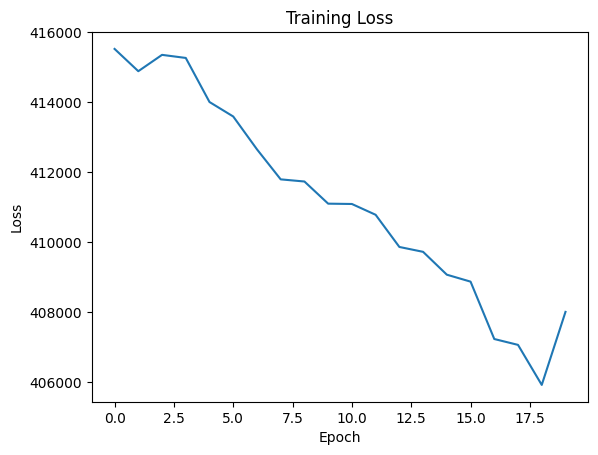

In [45]:
# ========================
# CELL 6: Training loop with tqdm + live loss
# ========================
EPOCHS = 20  # start small
BATCH_SIZE = 64

train_losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for X_batch, y_batch in pbar:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({"batch_loss": loss.item()})
    
    epoch_loss /= len(loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")

# Plot training loss
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd

# Config
SEQ_LEN = 30   # shorter sequences for faster runs
BATCH_SIZE = 128
VAL_SPLIT = 0.1


In [13]:
class OnTheFlyCovidDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, seq_len):
        self.data = df[feature_cols].values.astype(np.float32)
        self.target = df[target_col].values.astype(np.float32)
        self.seq_len = seq_len
        self.length = len(df) - seq_len

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.seq_len]
        y = self.target[idx+self.seq_len]
        return torch.tensor(X), torch.tensor(y)


In [11]:
# Use a smaller subset first for debugging (optional)
df_small = df.iloc[:300_000]  

# Define feature & target columns
feature_cols = [col for col in df_small.columns if col not in ["target"]]  
target_col = "target"

# Create dataset
dataset = OnTheFlyCovidDataset(df_small, feature_cols, target_col, SEQ_LEN)

# Train/validation split
val_size = int(len(dataset) * VAL_SPLIT)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Dataset ready. Train: {len(train_dataset)} | Val: {len(val_dataset)} | Seq_len={SEQ_LEN}")


NameError: name 'df' is not defined

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out).squeeze(-1)

# Model init
input_dim = len(feature_cols)
model = LSTMModel(input_dim).to("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 🔹 Learning rate scheduler (decays when val loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# 🔹 Save folder for checkpoints
os.makedirs("checkpoints", exist_ok=True)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(X)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = criterion(preds, y)
            total_loss += loss.item() * len(X)
    return total_loss / len(loader.dataset)

# 🔹 Training loop with checkpoint saving
EPOCHS = 20
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    # Step scheduler
    scheduler.step(val_loss)

    # Save checkpoint each epoch
    checkpoint_path = f"checkpoints/model_epoch{epoch+1}.pth"
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_loss": val_loss
    }, checkpoint_path)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/model_best.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
